In [1]:
import math
import logging
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
class Problem:
    _graph: nx.Graph
    _alpha: float
    _beta: float

    def __init__(
        self,
        num_cities: int,
        *,
        alpha: float = 1.0,
        beta: float = 1.0,
        density: float = 0.5,
        seed: int = 42,
    ):
        rng = np.random.default_rng(seed)
        self._alpha = alpha
        self._beta = beta
        cities = rng.random(size=(num_cities, 2))
        cities[0, 0] = cities[0, 1] = 0.5

        self._graph = nx.Graph()
        self._graph.add_node(0, pos=(cities[0, 0], cities[0, 1]), gold=0)
        for c in range(1, num_cities):
            self._graph.add_node(c, pos=(cities[c, 0], cities[c, 1]), gold=(1 + 999 * rng.random()))

        tmp = cities[:, np.newaxis, :] - cities[np.newaxis, :, :]
        d = np.sqrt(np.sum(np.square(tmp), axis=-1))
        for c1, c2 in combinations(range(num_cities), 2):
            if rng.random() < density or c2 == c1 + 1:
                self._graph.add_edge(c1, c2, dist=d[c1, c2])

        assert nx.is_connected(self._graph)

    @property
    def graph(self) -> nx.Graph:
        return nx.Graph(self._graph)

    @property
    def alpha(self):
        return self._alpha

    @property
    def beta(self):
        return self._beta

    def cost(self, path, weight):
        dist = nx.path_weight(self._graph, path, weight='dist')
        return dist + (self._alpha * dist * weight) ** self._beta

    def baseline(self):
        total_cost = 0
        for dest, path in nx.single_source_dijkstra_path(
            self._graph, source=0, weight='dist'
        ).items():
            if dest == 0: continue
            cost = 0
            for c1, c2 in zip(path, path[1:]):
                cost += self.cost([c1, c2], 0)
                cost += self.cost([c1, c2], self._graph.nodes[dest]['gold'])
            logging.debug(
                f"dummy_solution: go to {dest} ({' > '.join(str(n) for n in path)} ({cost})"
            )
            total_cost += cost
        return total_cost

    def plot(self):
        plt.figure(figsize=(10, 10))
        pos = nx.get_node_attributes(self._graph, 'pos')
        size = [100] + [self._graph.nodes[n]['gold'] for n in range(1, len(self._graph))]
        color = ['red'] + ['lightblue'] * (len(self._graph) - 1)
        return nx.draw(self._graph, pos, with_labels=True, node_color=color, node_size=size)

In [3]:
def get_real_path_cost(problem, u, v, load, path_cache, edge_cache):
    """Calcola il costo fisico lungo il cammino minimo tra u e v."""
    if u == v: return 0.0
    path = path_cache[u][v]
    total_cost = 0.0
    for i in range(len(path) - 1):
        n1, n2 = path[i], path[i+1]
        d = edge_cache[(n1, n2)]
        total_cost += d + (problem.alpha * d * load) ** problem.beta
    return total_cost

def split_prins(problem, sequence, path_cache, edge_cache):
    """Algoritmo di Split per dividere la sequenza in rotte ottimali."""
    n = len(sequence)
    golds = [problem.graph.nodes[node]['gold'] for node in sequence]
    V = [float('inf')] * (n + 1)
    P = [0] * (n + 1)
    V[0] = 0.0

    for i in range(n):
        if V[i] == float('inf'): continue
        current_load = 0.0
        trip_cost = 0.0
        u = 0
        # Bounded Split (finestra a 40 nodi per efficienza)
        for j in range(i + 1, min(n + 1, i + 41)):
            v = sequence[j-1]
            trip_cost += get_real_path_cost(problem, u, v, current_load, path_cache, edge_cache)
            current_load += golds[j-1]
            return_cost = get_real_path_cost(problem, v, 0, current_load, path_cache, edge_cache)
            
            if V[i] + trip_cost + return_cost < V[j]:
                V[j] = V[i] + trip_cost + return_cost
                P[j] = i
            u = v
            
    routes = []
    curr = n
    while curr > 0:
        start = P[curr]
        routes.append([0] + sequence[start:curr] + [0])
        curr = start
    return V[n], routes[::-1]

In [16]:
# ==============================================================================
# 3. EDUCATION (LOCAL SEARCH COMPLETA SENZA SEMPLIFICAZIONI)
# ==============================================================================

def ls_relocate(tour):
    n = len(tour)
    i = random.randint(0, n - 1)
    node = tour[i]
    j = random.randint(0, n - 2)
    new_tour = tour[:i] + tour[i+1:]
    new_tour.insert(j, node)
    return new_tour

def ls_swap(tour):
    i, j = random.sample(range(len(tour)), 2)
    new_tour = tour[:]
    new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    return new_tour

def ls_2opt(tour):
    i, j = sorted(random.sample(range(len(tour)), 2))
    new_tour = tour[:]
    new_tour[i:j+1] = new_tour[i:j+1][::-1]
    return new_tour

def educate(problem, chromosome, path_cache, edge_cache):
    max_attempts = 20 
    improved = True
    best_chrom = chromosome[:]
    best_cost, _ = split_prins(problem, best_chrom, path_cache, edge_cache)
    
    while improved:
        improved = False
        for _ in range(max_attempts):
            cand = ls_relocate(best_chrom)
            c_cand, _ = split_prins(problem, cand, path_cache, edge_cache)
            if c_cand < best_cost:
                best_cost, best_chrom, improved = c_cand, cand, True
                break
        if improved: continue

        for _ in range(max_attempts):
            cand = ls_swap(best_chrom)
            c_cand, _ = split_prins(problem, cand, path_cache, edge_cache)
            if c_cand < best_cost:
                best_cost, best_chrom, improved = c_cand, cand, True
                break
        if improved: continue

        for _ in range(max_attempts):
            cand = ls_2opt(best_chrom)
            c_cand, _ = split_prins(problem, cand, path_cache, edge_cache)
            if c_cand < best_cost:
                best_cost, best_chrom, improved = c_cand, cand, True
                break
    return best_chrom

In [17]:
def ox_crossover(p1, p2):
    a, b = sorted(random.sample(range(len(p1)), 2))
    child = [-1] * len(p1)
    child[a:b+1] = p1[a:b+1]
    p2_vals = [x for x in p2 if x not in set(child)]
    cur = 0
    for i in range(len(child)):
        if child[i] == -1:
            child[i] = p2_vals[cur]
            cur += 1
    return child


In [18]:
def generate_nearest_neighbor(problem, dist_cache):
    num_nodes = len(problem.graph)
    unvisited = set(range(1, num_nodes))
    curr, tour = 0, []
    while unvisited:
        next_node = min(unvisited, key=lambda n: dist_cache[curr][n])
        tour.append(next_node)
        unvisited.remove(next_node)
        curr = next_node
    return tour

def generate_clarke_wright(problem, dist_cache):
    n = len(problem.graph)
    nodes = list(range(1, n))
    savings = []
    for i in range(1, n):
        for j in range(i + 1, n):
            s = dist_cache[0][i] + dist_cache[0][j] - dist_cache[i][j]
            if s > 0: savings.append((s, i, j))
    savings.sort(key=lambda x: x[0], reverse=True)
    
    routes = {i: [i] for i in nodes}
    for _, i, j in savings:
        r1, r2 = routes[i], routes[j]
        if r1 is not r2:
            if r1[-1] == i and r2[0] == j: new = r1 + r2
            elif r2[-1] == j and r1[0] == i: new = r2 + r1
            elif r1[0] == i and r2[0] == j: new = r1[::-1] + r2
            elif r1[-1] == i and r2[-1] == j: new = r1 + r2[::-1]
            else: continue
            for node in new: routes[node] = new
    
    final_tour, seen = [], set()
    for node in nodes:
        if node not in seen:
            final_tour.extend(routes[node]); seen.update(routes[node])
    return final_tour

def get_initial_population(problem, pop_size, path_cache, dist_cache, edge_cache):
    population = []
    nn = generate_nearest_neighbor(problem, dist_cache)
    population.append([0, nn]) 
    
    cw = generate_clarke_wright(problem, dist_cache)
    population.append([0, cw])
    
    base_nodes = list(range(1, len(problem.graph)))
    while len(population) < pop_size:
        chrom = base_nodes[:]
        random.shuffle(chrom)
        population.append([0, chrom])

    for ind in population:
        ind[0], _ = split_prins(problem, ind[1], path_cache, edge_cache)
    return population

In [ ]:
def run_classic_ga(problem, pop_size=50, max_gen=500):
    path_cache = dict(nx.all_pairs_dijkstra_path(problem.graph, weight='dist'))
    edge_cache = {(u, v): d['dist'] for u, v, d in problem.graph.edges(data=True)}
    edge_cache.update({(v, u): d for (u, v), d in edge_cache.items()})
    
    num_nodes = len(problem.graph)
    base_nodes = list(range(1, num_nodes))
    population = []
    for _ in range(pop_size):
        chrom = base_nodes[:]
        random.shuffle(chrom)
        cost, _ = split_prins(problem, chrom, path_cache, edge_cache)
        population.append([cost, chrom])
    
    best_cost = float('inf')
    stagnation = 0
    
    for gen in range(max_gen):
        population.sort(key=lambda x: x[0])
        if population[0][0] < best_cost:
            best_cost, stagnation = population[0][0], 0
        else:
            stagnation += 1
        
        mut_rate = 0.5 if stagnation > 50 else 0.1
        new_pop = [population[0]] 
        
        while len(new_pop) < pop_size:
            p1, p2 = random.sample(population[:pop_size//2], 2)
            child = ox_crossover(p1[1], p2[1])
            if random.random() < mut_rate:
                child = ls_swap(child)
            
            cost, _ = split_prins(problem, child, path_cache, edge_cache)
            new_pop.append([cost, child])
        population = new_pop
    return best_cost

In [19]:
def run_hgs(problem, pop_size=30, max_gen=50):
    path_cache = dict(nx.all_pairs_dijkstra_path(problem.graph, weight='dist'))
    dist_cache = dict(nx.all_pairs_dijkstra_path_length(problem.graph, weight='dist'))
    edge_cache = {(u, v): d['dist'] for u, v, d in problem.graph.edges(data = True)}
    edge_cache.update({(v, u): d for (u, v), d in edge_cache.items()})

    population_raw = get_initial_population(problem, pop_size, path_cache, dist_cache, edge_cache)
    
    population = []
    for cost, chrom in population_raw:
        chrom = educate(problem, chrom, path_cache, edge_cache)
        cost, routes = split_prins(problem, chrom, path_cache, edge_cache)
        population.append([cost, chrom, routes])

    for gen in range(max_gen):
        population.sort(key=lambda x: x[0])
        
        p1, p2 = population[random.randint(0, 5)][1], population[random.randint(0, 15)][1]
        
        child = ox_crossover(p1, p2)
        
        child = educate(problem, child, path_cache, edge_cache)
        cost, routes = split_prins(problem, child, path_cache, edge_cache)
        
        if cost < population[-1][0]:
            population.pop()
            population.append([cost, child, routes])
            
    return min(ind[0] for ind in population)

In [8]:

if __name__ == "__main__":
    prob = Problem(num_cities=50, beta=2.0, density=1.0)
    print(f"--- ANALISI SU 50 CITTÀ (B=2.0) ---")
    print(f"Baseline: {prob.baseline():.2f}")
    

    
    # Test HGS
    res_hgs = run_hgs(prob, pop_size=30, max_gen=50)
    print(f"Hybrid Genetic Search: {res_hgs:.2f}")

--- ANALISI SU 50 CITTÀ (B=2.0) ---
Baseline: 2121786.14
Classic GA: 1879007.21


KeyboardInterrupt: 

In [21]:
prob = Problem(num_cities=100, beta=2.0, density=1.0)
res_hgs = run_hgs(prob, pop_size=30, max_gen=50)
print(f"Hybrid Genetic Search: {res_hgs:.2f}")

KeyboardInterrupt: 

In [ ]:
import math
import random
import time
import networkx as nx
import numpy as np
from itertools import combinations

import logging
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from icecream import ic

class Problem:
    _graph: nx.Graph
    _alpha: float
    _beta: float

    def __init__(
        self,
        num_cities: int = 30,
        *,
        alpha: float = 1.0,
        beta: float = 1.0,
        density: float = 0.5,
        seed: int = 42,
    ):
        rng = np.random.default_rng(seed)
        self._alpha = alpha
        self._beta = beta
        cities = rng.random(size=(num_cities, 2))
        cities[0, 0] = cities[0, 1] = 0.5

        self._graph = nx.Graph()
        self._graph.add_node(0, pos=(cities[0, 0], cities[0, 1]), gold=0)
        for c in range(1, num_cities):
            self._graph.add_node(c, pos=(cities[c, 0], cities[c, 1]), gold=(1 + 999 * rng.random()))

        tmp = cities[:, np.newaxis, :] - cities[np.newaxis, :, :]
        d = np.sqrt(np.sum(np.square(tmp), axis=-1))
        for c1, c2 in combinations(range(num_cities), 2):
            if rng.random() < density or c2 == c1 + 1:
                self._graph.add_edge(c1, c2, dist=d[c1, c2])

        assert nx.is_connected(self._graph)

    @property
    def graph(self) -> nx.Graph:
        return nx.Graph(self._graph)

    @property
    def alpha(self):
        return self._alpha

    @property
    def beta(self):
        return self._beta

    def cost(self, path, weight):
        dist = nx.path_weight(self._graph, path, weight='dist')
        return dist + (self._alpha * dist * weight) ** self._beta

    def baseline(self):
        total_cost = 0
        for dest, path in nx.single_source_dijkstra_path(
            self._graph, source=0, weight='dist'
        ).items():
            cost = 0
            for c1, c2 in zip(path, path[1:]):
                cost += self.cost([c1, c2], 0)
                cost += self.cost([c1, c2], self._graph.nodes[dest]['gold'])
            logging.debug(
                f"dummy_solution: go to {dest} ({' > '.join(str(n) for n in path)} ({cost})"
            )
            total_cost += cost
        return total_cost

    def plot(self):
        plt.figure(figsize=(10, 10))
        pos = nx.get_node_attributes(self._graph, 'pos')
        size = [100] + [self._graph.nodes[n]['gold'] for n in range(1, len(self._graph))]
        color = ['red'] + ['lightblue'] * (len(self._graph) - 1)
        return nx.draw(self._graph, pos, with_labels=True, node_color=color, node_size=size)


def get_fast_caches(problem):
    return dict(nx.all_pairs_dijkstra_path_length(problem._graph, weight='dist'))

def fast_split(sequence, dist_cache, golds, alpha, beta, max_tour=20):

    n = len(sequence)
    V = [1e30] * (n + 1)
    P = [0] * (n + 1)
    V[0] = 0.0
    
    for i in range(n):
        if V[i] >= 1e29: continue
        current_load = 0.0
        trip_cost = 0.0
        u = 0 
        
        limit = min(n + 1, i + max_tour)
        for j in range(i + 1, limit):
            v = sequence[j-1]
            
            d_uv = dist_cache[u][v]
            trip_cost += d_uv + (alpha * d_uv * current_load) ** beta
            
            current_load += golds[v]
            
            d_v0 = dist_cache[v][0]
            return_cost = d_v0 + (alpha * d_v0 * current_load) ** beta
            
            total_trip = trip_cost + return_cost
            
            if V[i] + total_trip < V[j]:
                V[j] = V[i] + total_trip
                P[j] = i
            u = v
    return V[n], P

def fast_educate(best_chrom, dist_cache, golds, alpha, beta):
    best_cost, _ = fast_split(best_chrom, dist_cache, golds, alpha, beta)
    improved = True
    n = len(best_chrom)
    
    while improved:
        improved = False
        for _ in range(50):
            i, j = sorted(random.sample(range(n), 2))
            cand = best_chrom[:i] + best_chrom[i:j+1][::-1] + best_chrom[j+1:]
            c, _ = fast_split(cand, dist_cache, golds, alpha, beta)
            if c < best_cost:
                best_cost, best_chrom, improved = c, cand, True; break
                
            i, j = random.sample(range(n), 2)
            cand = best_chrom[:]
            cand[i], cand[j] = cand[j], cand[i]
            c, _ = fast_split(cand, dist_cache, golds, alpha, beta)
            if c < best_cost:
                best_cost, best_chrom, improved = c, cand, True; break
    return best_chrom

def run_hgs_optimized(problem, pop_size=40, max_gen=100):
    t0 = time.time()
    dist_cache = get_fast_caches(problem)
    golds = {n: problem._graph.nodes[n]['gold'] for n in problem._graph.nodes}
    alpha, beta = problem.alpha, problem.beta
    num_nodes = len(problem._graph)
    base = list(range(1, num_nodes))
    
    population = []
    for _ in range(pop_size):
        chrom = base[:]
        random.shuffle(chrom)
        chrom = fast_educate(chrom, dist_cache, golds, alpha, beta)
        cost, _ = fast_split(chrom, dist_cache, golds, alpha, beta)
        population.append([cost, chrom])

    for gen in range(max_gen):
        population.sort(key=lambda x: x[0])
        
        p1 = population[random.randint(0, 5)][1]
        p2 = population[random.randint(0, 10)][1]
        
        child = ox_crossover(p1, p2)
        
        child = fast_educate(child, dist_cache, golds, alpha, beta)
        cost, _ = fast_split(child, dist_cache, golds, alpha, beta)
        
        if cost < population[-1][0]:
            if not any(abs(cost - ind[0]) < 1e-4 for ind in population):
                population.pop()
                population.append([cost, child])
                
    best_final = min(ind[0] for ind in population)
    print(f"HGS Optimized terminato in {time.time()-t0:.2f}s")
    return best_final

def ox_crossover(p1, p2):
    size = len(p1)
    a, b = sorted(random.sample(range(size), 2))
    child = [-1] * size
    child[a:b+1] = p1[a:b+1]
    p2_vals = [x for x in p2 if x not in set(child)]
    cur = 0
    for i in range(size):
        if child[i] == -1:
            child[i] = p2_vals[cur]
            cur += 1
    return child

if __name__ == "__main__":
    p_test = Problem(num_cities=100, alpha=0.5, beta=2.0, density=0.5)
    print(f"Baseline: {p_test.baseline():.2f}")
    
    best_hgs = run_hgs_optimized(p_test, pop_size=30, max_gen=300)
    
    print(f"HGS Final Result: {best_hgs:.2f}")
    print(f"Miglioramento: {((p_test.baseline() - best_hgs) / p_test.baseline() * 100):.2f}%")

In [ ]:
# Test GA
prob = Problem(num_cities=100, beta=2.0, density=1.0)
res_ga = run_classic_ga(prob, pop_size=30, max_gen=100)
print(f"Classic GA: {res_ga:.2f}")

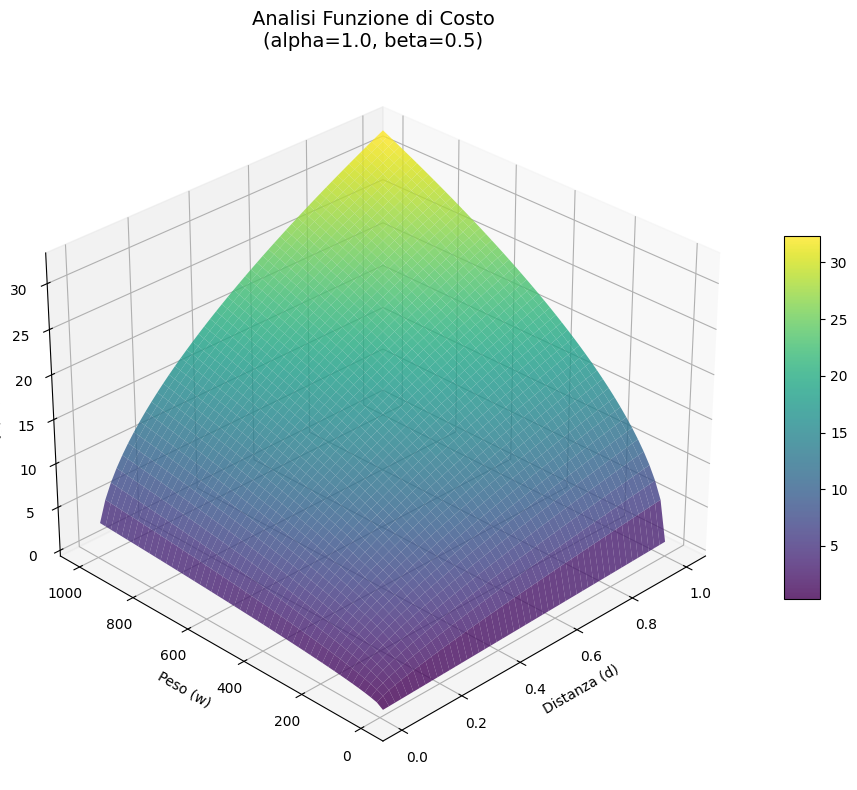

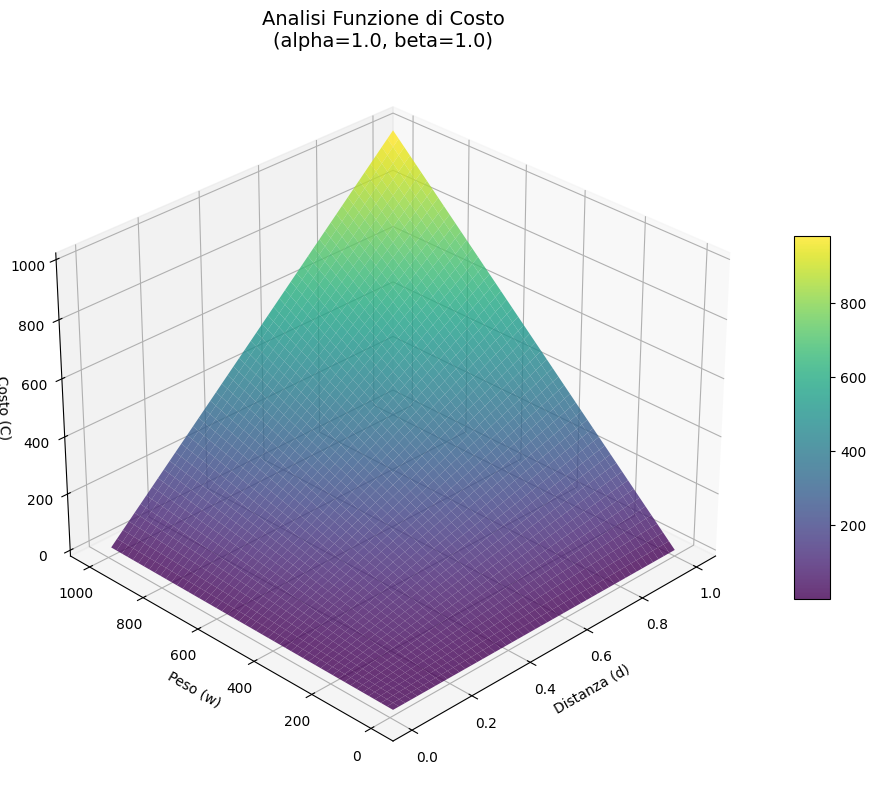

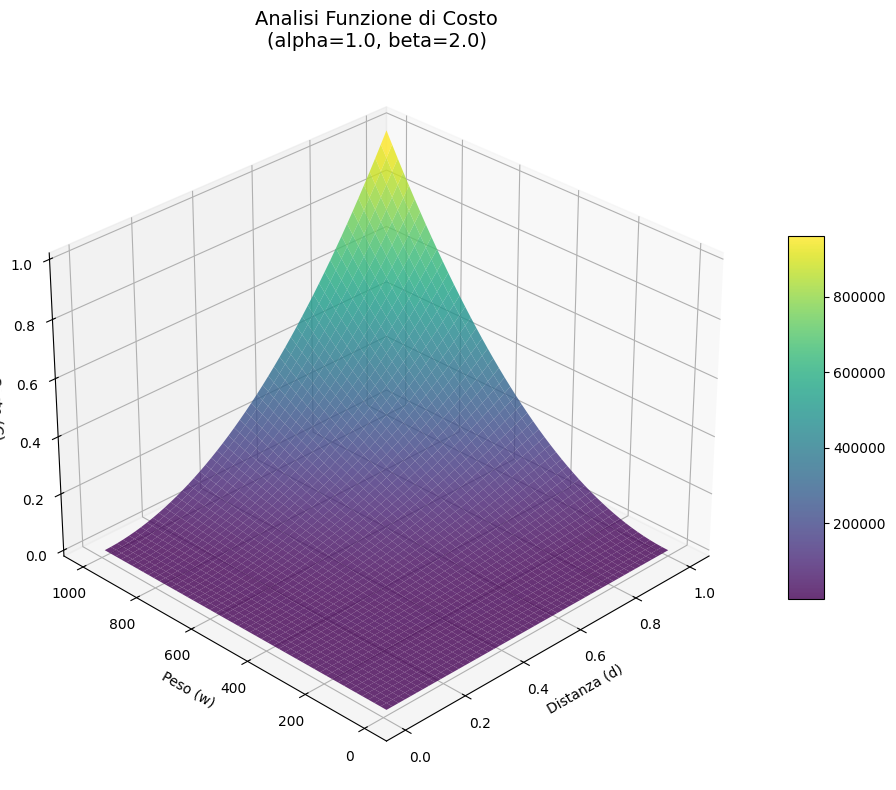

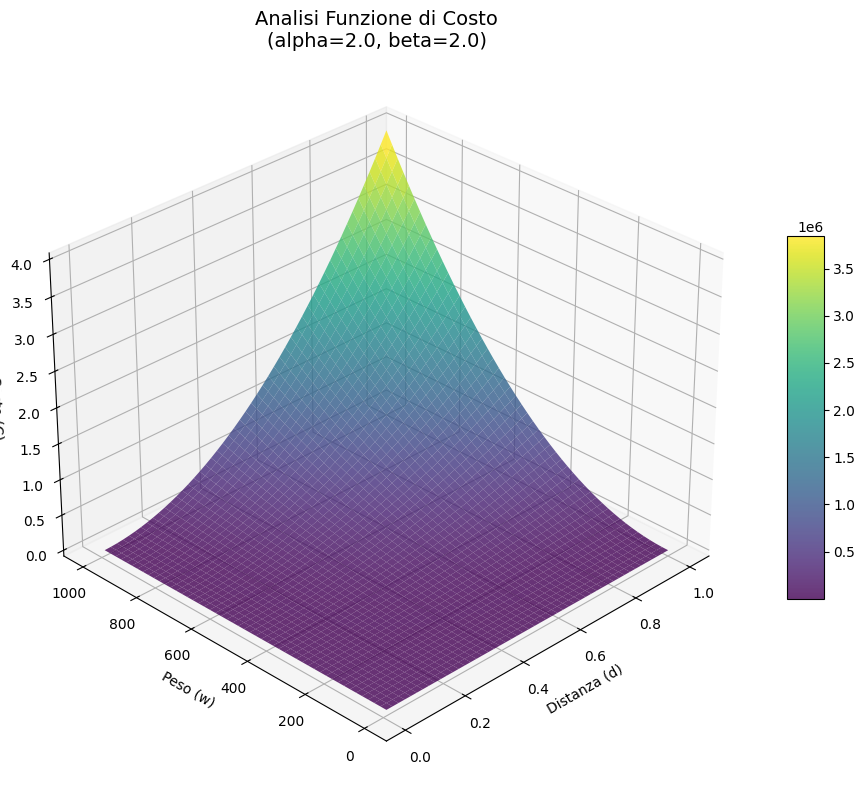

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_cost_analysis_3d(alpha, beta, avg_dist=0.5084, avg_weight=466):
    d_vals = np.linspace(0.01, 1.0, 50)
    w_vals = np.linspace(0, 1000, 50)
    D, W = np.meshgrid(d_vals, w_vals)

    COST = D + (alpha * D * W)**beta

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(D, W, COST, cmap='viridis', edgecolor='none', alpha=0.8)

    ax.set_xlabel('Distanza (d)')
    ax.set_ylabel('Peso (w)')
    ax.set_zlabel('Costo (C)')
    ax.set_title(f'Analisi Funzione di Costo\n(alpha={alpha}, beta={beta})', fontsize=14)

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

    ax.view_init(elev=30, azim=225) 
    plt.tight_layout()
    plt.savefig('cost_function_3d.png')

plot_cost_analysis_3d(alpha=1.0, beta=0.5)
plot_cost_analysis_3d(alpha=1.0, beta=1.0)
plot_cost_analysis_3d(alpha=1.0, beta=2.0)
plot_cost_analysis_3d(alpha=2.0, beta=2.0)

